<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'> Previsão de Vazões de Rios</h1>
</div>


Esse trabalho tem como objetivo demonstrar o processo de projeção através de modelos de séries temporais. Para isso, utilizaremos os dados das vazões de um rio, fornecidos pelo Operador Nacional de Sistemas Elétrico (ONS), medidos mensalmente entre 1984 e 2004. Tais dados serão submetidos aos modelos de séries temporais em busca do mais adequado para esse estudo.

O processo inicia pela análise dos dados para verificar se estes estão dentro das característcas de estacionaridade e aderência à distribuição normal. No próximo passo é aplicada as técnicas de transformação para ajustar os dados a fim de alcançar as referidas características. Na sequência, será feito a modelagem para indicar qual algorítmo melhor se ajusta. Finalmente, será feita a validação comparando com as vazões de outros anos.

### Conteúdo:

1. Importação das bibliotecas

2. Análise dos dados
  - Carga dos Dados
  - Análise da Estrutura
  - Análise Exploratória
  - Estacionariedade
  - Aderência a Distribuição Normal
  - Decomposição da Série
  - Conclusão

3. Transformação da Série
  - Transformação
  - Estacionariedade
  - Aderência a Distribuição Normal
  - Conclusão

4. Modelagem
  - Análise da Autocorrelação
  - Treinamento do Modelo
  - Análise dos Resíduos
  - Análise do Ajuste
  - Funções de Projeção
  - Teste do Modelo
  - Conclusão

5. Validação
  - Validação de 2005
  - Validação de 2006
  - Conclusão

6. Resultado

  

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Importação das bibliotecas</h2>
</div>

In [1]:
%matplotlib inline

# Pacotes para manipulação de dados
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import Markdown, display

# Pacotes para apoio à plotagem.
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns

# Pacotes para apoio à análise das séries temporais.
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro, probplot

# Pacote para modelagem das séries temporais.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Análise de dados</h2>
</div>

Nesta seção:
  - Carga dos Dados
  - Análise da Estrutura
  - Análise Exploratória
  - Verificação da Estacionaridade
  - Aderência a Distribuição Normal.
  - Decomposição da Série
  - Conclusão

### 2.1. Carga de Dados

Serão carregados 20 anos de medção das vazões com periodicidade mensal.

In [2]:
date_parser = lambda dates: datetime.strptime(dates, '%d/%m/%Y')

data = pd.read_csv('Vazoes_Mensais.csv', 
                   sep=";", header=0, index_col=0, date_parser=date_parser)

### 2.2. Análise da Estrutura

A estrutura dos dados, apresentada abaixo, correspondem as datas e as vazões. As datas estão em um intervalo de 01/01/1984 até 01/12/2004 e as vazões apresentam 252 medições mensais.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1984-01-01 to 2004-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Vazao   252 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


### 2.3. Análise Exploratória

Nesta subseção:

  - Quantidade de Dados.
  - Existência de dados nulos e como completá-los.
  - Existência de vazões com valor zero.
  - Amostragem de 20 meses para uma checagem geral
  

In [4]:
def print_markdown(string, color='blue'):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    return

In [5]:
print(f'Quantidade de valores: {len(data)}')
print(f'Quantidade de dados nulos: {data["Vazao"].isnull().sum()}')
print(f'Quantidade de valores zerados: {len(data.loc[data["Vazao"] == 0].value_counts())}\n')
print_markdown('*** Pelo fato de não existir dados com valores zero, na seção de transformação da série poderá utilizar a função logarítmica. ***')

Quantidade de valores: 252
Quantidade de dados nulos: 0
Quantidade de valores zerados: 0



<span style='color:blue'>*** Pelo fato de não existir dados com valores zero, na seção de transformação da série poderá utilizar a função logarítmica. ***</span>

In [6]:
data.head(20)

,Vazao
Data,
1984-01-01,2192
1984-02-01,1315
1984-03-01,994
1984-04-01,914
1984-05-01,861
1984-06-01,577
1984-07-01,466
1984-08-01,482
1984-09-01,547


### 2.4. Estacionariedade

A estacionariedade é um conjunto de carterísticas sendo a média, variância e a autocorrelação constantes no tempo, sem tendência e flutuação periódica, ou seja, sazonalidade.

Para comprovar a estacionariedade, aplica-se o teste estatístico de Dickey-Fuller que especifica a hipótese nula como uma série que não é estacionária e em contra partida tem como hipótse alternativa a série sendo estacionária. https://medium.datadriveninvestor.com/interpreting-results-of-dicky-fuller-test-for-time-series-analysis-4bb1e98f242b

No gráfico de vazões abaixo pode ser observada as propriedades citadas e toma-se como pressuposto que a série é estacionária. Então, a aplicação do teste de Dickey-Fuller confirmou a estacionariedade.

In [7]:
# Função de aplicação do teste de Dickey-Fuller que retorna um valor binnário 
# sendo True para estacionária e False para não estacionária.

def isStationary(values, print_results=False):
    dfuller = adfuller(values, autolag='AIC')
    result = pd.Series(dfuller[0:4], index=['Teste', 'Valor-p', '# Lags', '# Obs'])
    for key, value in dfuller[4].items():
        result[f'Valores Críticos({key})'] = value
    if print_results:
        print(result)
    is_stationary = True if result['Valor-p'] < 0.5 else False
    return is_stationary

Text(0, 0.5, 'Vazao')

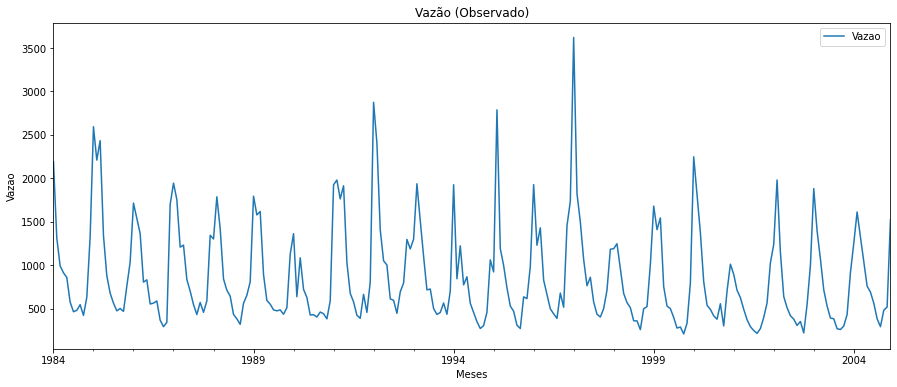

In [8]:
# Plotagem das Vazões ao longo do tempo.

data.plot()
plt.title('Vazão (Observado)')
plt.xlabel('Meses')
plt.ylabel('Vazao')

In [9]:
# Verificação da estacionariedade.

if isStationary(data.Vazao.values):
    print_markdown('*** Série é estacionária. ***')
else:
    print_markdown('*** Série não é estacionária. ***')


<span style='color:blue'>*** Série é estacionária. ***</span>

### 2.5. Aderência a Distribuição Normal.

O histograma é um gráfico de barras para análises estatísticas que mostra a distribuição de probabilidades de acontecimentos em uma amostra de dados. A distribuição normal se dá quando o histograma toma uma forma de sino simétrico em relação a média e a largura representada pelo desvio padrão, permitindo fazer previsões sobre um fenomeno.

https://www.investopedia.com/terms/b/bell-curve.asp

O gráfico quantile-quantile é um método para comparar um conjunto de dados contra uma distribuição de probabilidades teórica. Se os dados amostrais estiverem próximos do modelo teórico, logo existe a chance dos dados fazerem parte de uma distribuição normal.

https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot

Porém, a análise gráfica não é suficiente para afirmar se a distibuição é normal, pela fato de existirem desvio imperceptíveis, portanto é necessário aplicar um teste estatístico para verificar se a amostra está aderente à normalidade. Entre diversos testes de aderência a distribuição normal foi escolhido Shapiro-Wilk.

https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

Esses três instrumentos serão utilizados para confirmar se os dados sobre as vazões seguem a distribuição normal, caso contrário será necessário aplicar uma transformação para aproximar da referida distribuição probabilistica.


#### Plotagem do histograma

O histograma sobre a série das vazões não converge para uma curva normal, o que indica a necessidade de transfomação para a distribuição de probabilidade normal.

Text(0.5, 1.0, 'Histograma da Série das Vazões')

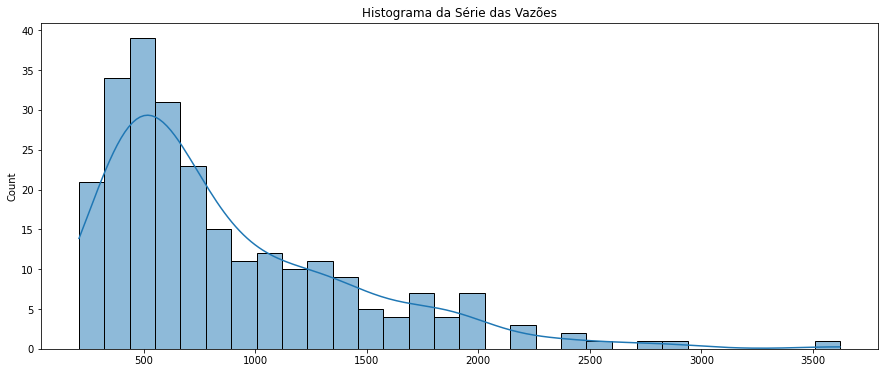

In [10]:
sns.histplot(data=data.Vazao.values, kde=True, bins=30)
plt.title('Histograma da Série das Vazões')

#### Plotagem do quantile-quantile

No gráfico Quantile-Quantile abaixo, os pontos da amostra não se aproximan da reta que repesenta a distribuição teórica, ou seja, a série não segue a distribuição normal.

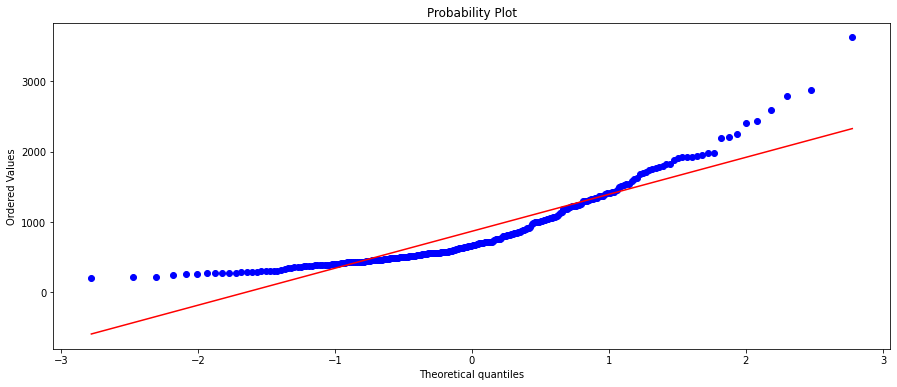

In [11]:
probplot(data.Vazao.values, dist="norm", plot=plt)
plt.show()

#### Teste Shapiro-Wilk para verificar a aderência a distribuição normal.

A aplicação desse teste confirma pela terceira vez que os dados das vazões não seguem a distribuição de probabilidade normal, o que apoia na transformação, como será visto no capítulo 3.

In [12]:
# Extrai uma amostra para aplicar o teste de Shapiro-Wilk.
data_range = [int((len(data)/2)) - 10, int((len(data)/2) + 10)]
data_sample = data.iloc[data_range[0]:data_range[1]]

# Aplica o teste de Shapiro-Wilk.
shapiro_test = shapiro(data_sample.Vazao.values)
print('Teste de Shapiro-Wilk')
print(f'Statisct Test: {shapiro_test.statistic}')
adhesion = 'segue a distribuição normal' if shapiro_test.pvalue > 0.05 else 'não segue a distribuição normal' 
result = f'p-value: {round(shapiro_test.pvalue, 5)} - Série Original {adhesion}'

print_markdown('*** {}. ***'.format(result))

Teste de Shapiro-Wilk
Statisct Test: 0.7943820953369141


<span style='color:blue'>*** p-value: 0.00071 - Série Original não segue a distribuição normal. ***</span>

###### 2.6. Decomposição da Série.

A decomposição é o processo de extrair da série em estudo em três séries diferentes: tednência, sazonalidade e flutuação aleatória. A tendência mostra se a série sobre ou desce, mesmo que discretamente. A sazonalidade informa os períodos fixos que formam um padrão de repetição, diferentemente do ciclo que é aleatório. A flutação aleatória são os dados que restaram após a remoção da tendência e da sazonalidade, mais conhecido como resíduos. Essas três apoiam a interpretação comportamental da série em estudo para fazer a recomposição da série que servirá para fazer previsões.

https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7

A decomposição mostrada abaixo mostra que há tendência discreta ao longo dos anos, a sazonalidade mostra o padrão de repetções a cada 6 meses e o resídui branco giria em torno de 1 com um desvio padrão próximo a média.

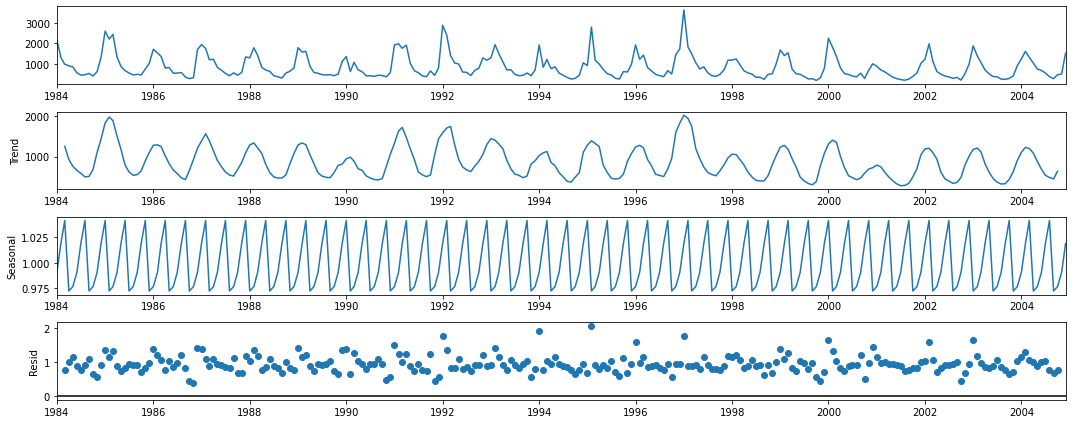

In [13]:

decompose_model = ['additive', 'multiplicative']
decompose = seasonal_decompose(data,  model=decompose_model[1], period=5)
decompose.plot()
plt.show()

### 2.7. Conclusão

A série temporal em estudo é estacionarida, não segue a distribuição normal, tem uma leve tendência e uma acentuada sazonalidade, ou seja, passará pro um processo de transformação de forma a alcançar as características necessárias para fazer a modelagem.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Transformação da Série</h2>
</div>

Nesta Seção:
  - Transformação da Série
  - Aderência a Distribuição Normal
  - Aplicação Teste de Estacionariada

### 3.1. Transformação


====================================================
Como visto no capítulo 2, há indícios apontando a necessidade de transformar a série para que esteja adequada a modelagem de séries temporais.

O primeiro passo foi aproximar da aderência da distribuição normal, com a aplicação do logaritmo sobre os dados das vazões. Para o segundo passo, foi utilizado o processo de diferenciação com uma latência de 12 meses, para a remoção da sazonalidade ao longo de um ano. No passo final, foi empregado novamente a diferenciação, com a latência de um mês, para a remoção da tendência.

In [14]:
series = data.copy()

if shapiro_test.pvalue <= 0.05:
    # Transforma a série para obter a aderência a distribuição normal.
    series['Vazao'] = np.log(series['Vazao'])
    # Copia a série transformada para fazer a diferenciação.
    seriesd = series.copy()
    # Remove a sazonalidade a cada 12 meses.
    seriesd['Vazao'] = seriesd['Vazao'].diff(periods=12) 
    seriesd.dropna(axis=0, inplace=True)
    # Aplica a primeira ordem para remoção da tendência.
    seriesd['Vazao'] = seriesd['Vazao'].diff(periods=1)
    seriesd.dropna(axis=0, inplace=True)

#### Plotando a série transformada.

O gráfico da série transformada mostra a série na escala logarítmica centrada na média zero, sem tendência e sazonalidade.

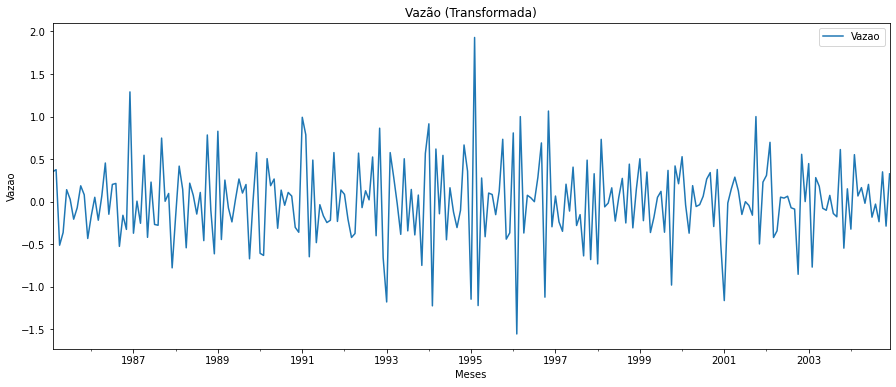

In [15]:
if shapiro_test.pvalue <= 0.05:
    seriesd.plot()
    plt.title('Vazão (Transformada)')
    plt.xlabel('Meses')
    plt.ylabel('Vazao')

### 3.2. Aderência a Distribuição Normal

#### Plotagem do histograma

Após a transformação, o histograma apresenta uma aproximação curva normal de Gauss, atendo as caracteristicas de uma série temporal.

https://www.inf.ufsc.br/~andre.zibetti/probabilidade/normal.html

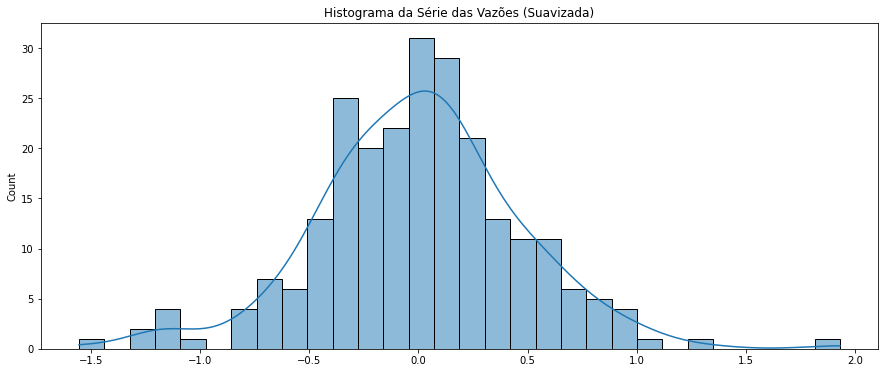

In [16]:
if shapiro_test.pvalue <= 0.05:
    sns.histplot(data=seriesd.Vazao.values, kde=True, bins=30)
    plt.title('Histograma da Série das Vazões (Suavizada)')


#### Plotagem do quantile-quantile

O gráfico Quantile-Quantile confirma a aproximação da curva normal da série transformada.

O gráfico abaixo não apresenta uma linearidade confirmando que a série segue a distribuição normal.

https://pt.wikipedia.org/wiki/Gr%C3%A1fico_Q-Q

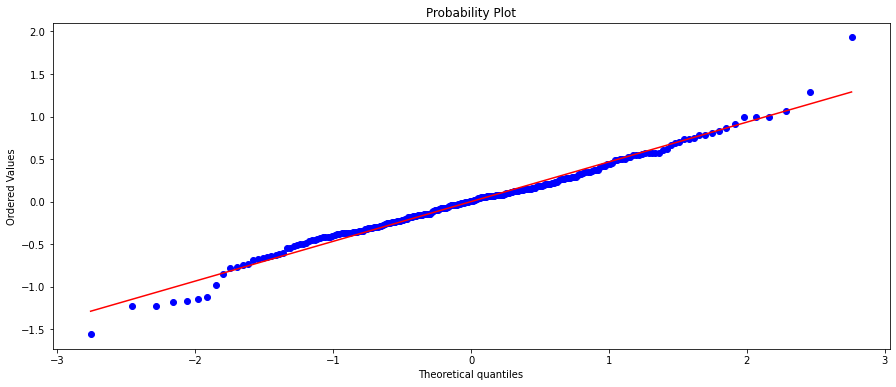

In [17]:
if shapiro_test.pvalue <= 0.05:
    probplot(seriesd.Vazao.values, dist="norm", plot=plt)
    plt.show()

#### Teste de Shapiro-Wilk para verfifica a aderência a distribuição normal sobre a série transformada.

https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

In [18]:
if shapiro_test.pvalue <= 0.05:
    # Extrai uma amostra para aplicar o teste de Shapiro-Wilk.
    data_range = [int((len(seriesd)/2)) - 10, int((len(seriesd)/2) + 10)]
    data_sample = seriesd.iloc[data_range[0]:data_range[1]]
    # Aplica o teste de Shapiro-Wilk.
    shapiro_test = shapiro(data_sample.Vazao.values)
    print('Teste de Shapiro-Wilk')
    print(f'Statisct Test: {shapiro_test.statistic}')
    adhesion = 'segue a distribuição normal' if shapiro_test.pvalue > 0.05 else 'não segue a distribuição normal' 
    print(f'p-value: {round(shapiro_test.pvalue, 5)} - Série Transformada {adhesion}.')

Teste de Shapiro-Wilk
Statisct Test: 0.9354494214057922
p-value: 0.19646 - Série Transformada segue a distribuição normal.


### 3.3. Verificação da Estacionaridade

#### Teste de estacionaridade sobre a série transformada.

In [19]:
if shapiro_test.pvalue > 0.05:
    if isStationary(seriesd.Vazao.values):
        print('Série transformada é estacionária')
    else:
        print('Série transformada não é estacionária')       


Série transformada é estacionária


### 3.4. Conclusão

O histograma e o gráfico quantile-quantile exibe que a série transformada segue a distribuição de probabilidade, confirmado pelo teste de Shapiro-Wilk. Com isso, pode-se dar continuidade a modelagem da série temporal.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Modelagem</h2>
</div>

Nesta Seção:
  - Análise da Autocorrelação
  - Treinamento
  - Análise dos Resíduos
  - Análise do Ajuste
  - Funções de Projeção
  - Teste
  - Conclusão


### 4.1. Análise da Autocorrelação



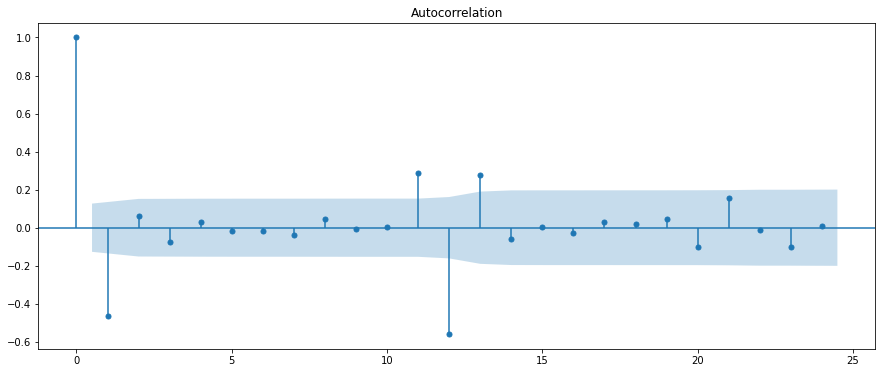

In [20]:
plot_acf(seriesd.Vazao.values)
plt.show()

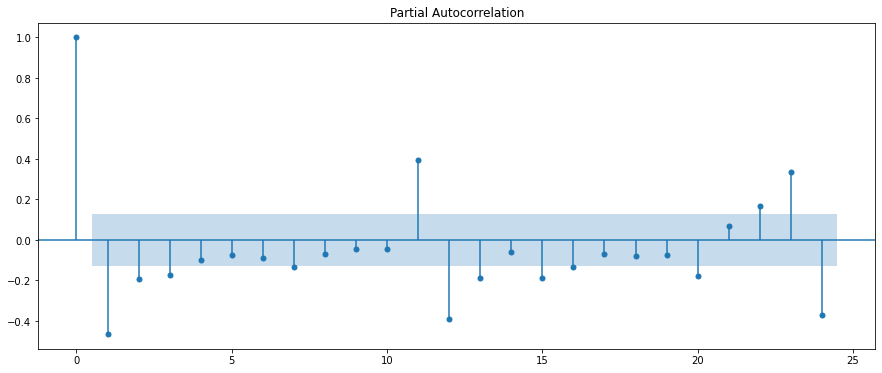

In [21]:
plot_pacf(seriesd.Vazao.values)
plt.show()

### 4.2. Treinamento

In [22]:
# Quebra os dados da série em treinamento e teste.
treshold = int(len(series) * 0.70)
train = series[:treshold]
test = series[treshold:]

In [23]:
# Aplica o modelo Arima para AutoRegressão e Média Móvel.
model = ARIMA(train, order=(3,1,1), seasonal_order=(1,1,1,12))

model_fit = model.fit()
print(model_fit.summary())


c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                                    SARIMAX Results                                     
Dep. Variable:                            Vazao   No. Observations:                  176
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -29.065
Date:                          Mon, 13 Sep 2021   AIC                             72.129
Time:                                  22:46:32   BIC                             93.785
Sample:                              01-01-1984   HQIC                            80.921
                                   - 08-01-1998                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2358      0.112      2.102      0.036       0.016       0.456
ar.L2          0.0607      0.087      0.702      0.

### 4.3. Análise dos Resíduos

c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


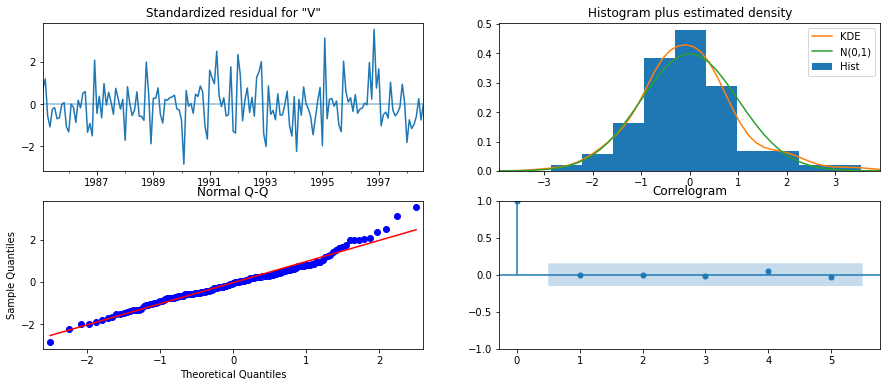

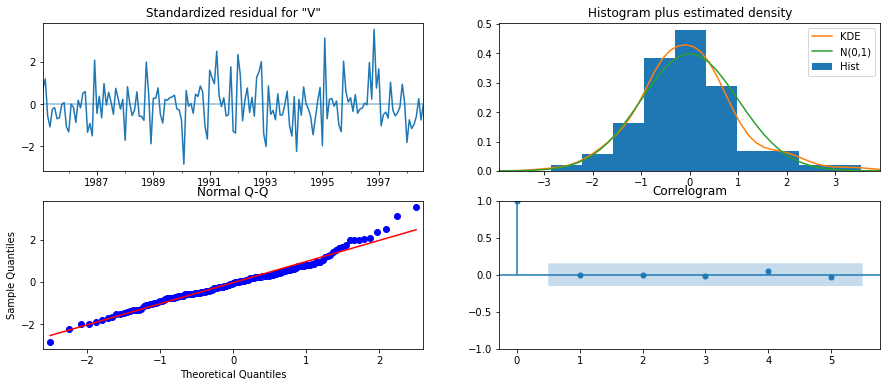

In [24]:
model_fit.plot_diagnostics(lags=5)


### 4.4 Análise do Ajuste

Text(0, 0.5, 'Vazão')

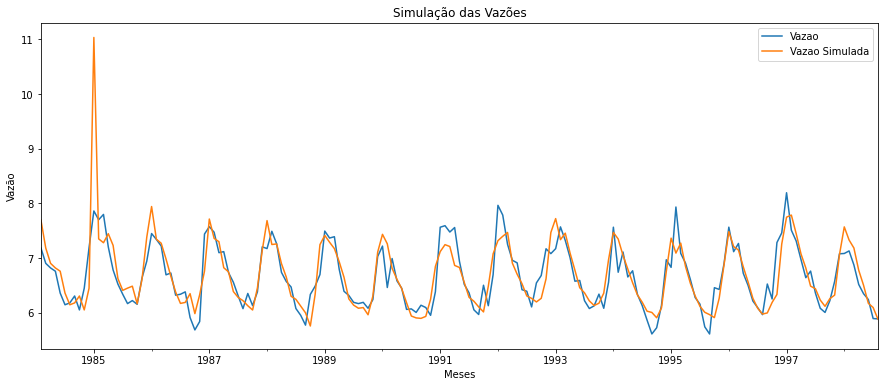

In [25]:
residual = pd.DataFrame(model_fit.resid, columns=['Vazao_Residual'])

series_adjusted = pd.concat([train, residual], axis=1)
series_adjusted.dropna(axis=0, inplace=True)
series_adjusted['Vazao Simulada'] = series_adjusted['Vazao'] - series_adjusted['Vazao_Residual']

series_adjusted.drop(columns=['Vazao_Residual'], inplace=True)

date = datetime.strptime('1984-01-01', '%Y-%m-%d')
series_adjusted = series_adjusted.drop(index=date)

series_adjusted.plot()
plt.title('Simulação das Vazões')
plt.xlabel('Meses')
plt.ylabel('Vazão')

### 4.5 Funções de Projeção

In [26]:
def get_forecast(months_ahead):
    result = model_fit.get_forecast(steps=len(test)+months_ahead)
    summ = pd.DataFrame(result.summary_frame(alpha=0.05))
    return summ

In [27]:
def get_confidence_interval(forecast_series):
    se_mim = round(forecast_series['mean_se'].min(), 4)
    se_max = round(forecast_series['mean_se'].max(), 4)
    # forecast_data.drop(columns=['mean_se'], inplace=True)
    return se_mim, se_max

In [28]:
def arrange_to_plot(forecast_series):
    '''
        Organiza os dados da série e os títulos do gráfico.
    '''
    forecast_series.drop(columns=['mean_se'], inplace=True)

    dict = {}
    for name in forecast_series.columns: 
        dict[name] = name
    dict['mean'] = 'Vazao Projetada'
    dict['mean_ci_lower'] = 'Intervalo Inferior'
    dict['mean_ci_upper'] = 'Intervalo Superior'
    forecast_series.columns = [value for key, value in dict.items()]
    #return forecast_series, se_mim, se_max
    return forecast_series

In [29]:
def plot_forecast(forecast_series, title):
    forecast_series.plot()
    plt.title(title)
    plt.xlabel('Meses')
    plt.ylabel('Vazão')

    plt.fill_between(forecast_series.index, 
                     forecast_series['Intervalo Inferior'], 
                     forecast_series['Intervalo Superior'], 
                     color='k', alpha=.15)
    return

In [30]:
def come_back_to_real(forecast_series):
    '''
        Os valores das vazões foram transformado para escala logarítmica na seção 3.1.
        
        A entrada desta função é a previsão da série temporal, então, retornará para os valores usuais das vazões.
    '''
    forecast_series['Vazao'] = round(np.exp(forecast_series['Vazao']), 1)
    forecast_series['Vazao Projetada'] = round(np.exp(forecast_series['Vazao Projetada']), 1)
    forecast_series['Intervalo Inferior'] = round(np.exp(forecast_series['Intervalo Inferior']), 1)
    forecast_series['Intervalo Superior'] = round(np.exp(forecast_series['Intervalo Superior']), 1)
    return forecast_series

In [31]:
def forecast(periods, title, series_to_forecast=None):
    summ = get_forecast(periods)

    forecast_data = pd.concat([series_to_forecast, summ], axis=1)

    se_mim, se_max = get_confidence_interval(forecast_data)

    forecast_data = arrange_to_plot(forecast_data)

    print(f'MSE: Mínimo = {round(se_mim, 4)}; Máximo = {round(se_max, 4)} e Diferença {round(se_max - se_mim, 4)}')

    plot_forecast(forecast_data, title)

    return forecast_data

### 4.6 Teste

Aplicação dos dados de teste para comparação com o resultado

MSE: Mínimo = 0.2672; Máximo = 0.5193 e Diferença 0.2521


,Vazao,Vazao Projetada,Intervalo Inferior,Intervalo Superior
1984-01-01,7.692570,NaN,NaN,NaN
1984-02-01,7.181592,NaN,NaN,NaN
1984-03-01,6.901737,NaN,NaN,NaN
1984-04-01,6.817831,NaN,NaN,NaN
1984-05-01,6.758095,NaN,NaN,NaN
...,...,...,...,...
2004-08-01,5.955837,5.865043,4.875281,6.854805
2004-09-01,5.683580,5.899650,4.900726,6.898574
2004-10-01,6.180017,6.005327,4.999843,7.010810
2004-11-01,6.253829,6.222390,5.210636,7.234144


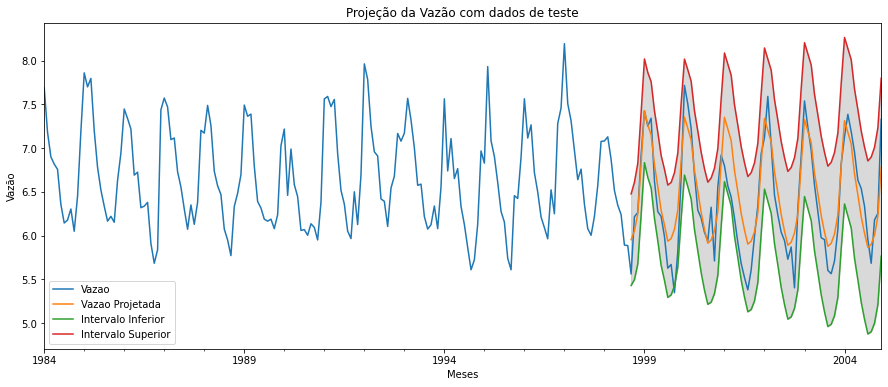

In [32]:
# Obtém a projeção para a série original.

forecast(0, 'Projeção da Vazão com dados de teste', series)

### 4.7. Conclusão

As plotagens das funções de autocorrelação e autocorrelação parcial indicam para um modelo de média móvel de ordem 1. Então, foi definido a ordem ARIMA(train, order=(0,1,1), seasonal_order=(1,1,1,12)) com AIC igual a 84.485.

Experimentando uma variação dos parâmetros, chegou-se ao modelo ARIMA(train, order=(3,1,1), seasonal_order=(1,1,1,12)) que apresentou o AIC igual a 79.898

Ambos apresentam resídulos aderente a distribuição normal com respectivo FAC sem apresentar auto-correlação, assim como na análise visual na Simulação dos Vazões, a diferença não foi significante.

Analisando o Mean Square Error mínimo e máximo dos dois modelos sobre a projeção (Seção 5), pode-se observar que o modelo 2 apresenta medidas mais adequadas. Portanto o modelo 2 foi selecionado.

Modelo MA    MSE: Mínimo = 0.2731; Máximo = 0.5318; AIC = 84.485

Modelo ARIMA MSE: Mínimo = 0.2635; Máximo = 0.3323; AIC = 79.898

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Validação</h2>
</div>

### 5.1.  Validação de 2005

Será incluído as vazões do ano de 2005 para comparar com o projetado.

MSE: Mínimo = 0.2672; Máximo = 0.5564 e Diferença 0.2892


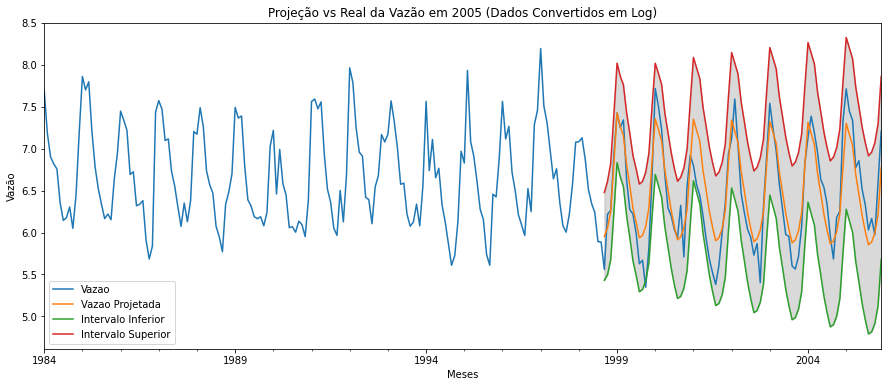

In [33]:
# A série termina em dez/2004 então será projetado 12 meses a frente

real_2005 = pd.read_csv('Vazoes-2005.csv', sep=';', header=0, index_col=0, date_parser=date_parser)

real_2005['Vazao'] = np.log(real_2005['Vazao'])

real_add = pd.concat([series, real_2005])

forecast_data = forecast(12, 'Projeção vs Real da Vazão em 2005 (Dados Convertidos em Log)', real_add)

             Vazao  Vazao Projetada  Intervalo Inferior  Intervalo Superior
2005-01-01  2239.0           1482.8               532.4              4129.8
2005-02-01  1713.0           1299.4               463.9              3639.1
2005-03-01  1541.0           1137.4               403.9              3203.1
2005-04-01   874.0            807.0               285.0              2285.0
2005-05-01   950.0            635.5               223.2              1809.4
2005-06-01   676.0            495.5               173.1              1418.2
2005-07-01   561.0            409.2               142.2              1177.5
2005-08-01   416.0            348.2               120.3              1007.3
2005-09-01   477.0            360.4               123.4              1052.3
2005-10-01   392.0            400.6               136.3              1177.3
2005-11-01   721.0            497.7               168.3              1472.0
2005-12-01  1352.0            872.0               293.0              2594.8


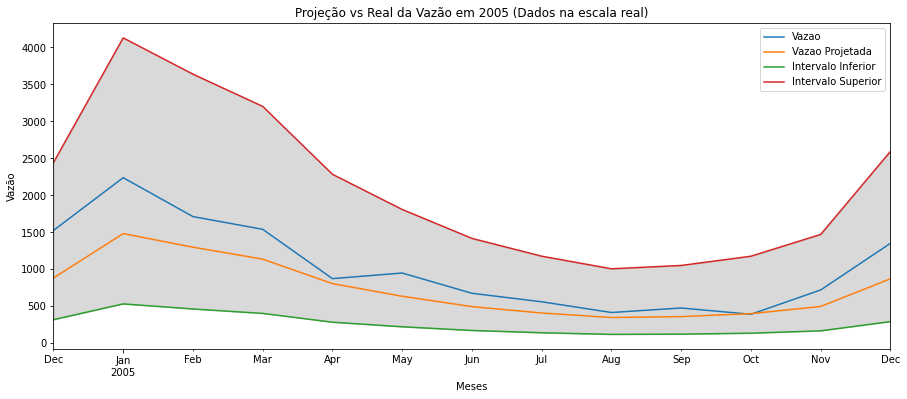

In [34]:
forecast_data = come_back_to_real(forecast_data)

threshold = datetime.strptime('2004-12-01', '%Y-%m-%d')

forecast_data = forecast_data.loc[forecast_data.index >= threshold]

print(forecast_data.tail(12))

plot_forecast(forecast_data, 'Projeção vs Real da Vazão em 2005 (Dados na escala real)')

### 5.2.  Validação de 2006


MSE: Mínimo = 0.2672; Máximo = 0.5935 e Diferença 0.3263


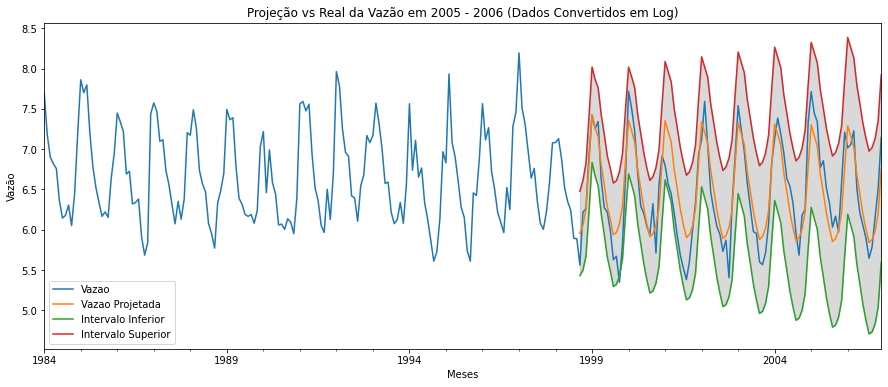

In [35]:
# A série termina em dez/2004 então será projetado 24 meses a frente

real_2006 = pd.read_csv('Vazoes-2006.csv', sep=';', header=0, index_col=0, date_parser=date_parser)

real_2006['Vazao'] = np.log(real_2006['Vazao'])

real_add = pd.concat([series, real_2005, real_2006])

forecast_data = forecast(24, 'Projeção vs Real da Vazão em 2005 - 2006 (Dados Convertidos em Log)', real_add)

             Vazao  Vazao Projetada  Intervalo Inferior  Intervalo Superior
2005-01-01  2239.0           1482.8               532.4              4129.8
2005-02-01  1713.0           1299.4               463.9              3639.1
2005-03-01  1541.0           1137.4               403.9              3203.1
2005-04-01   874.0            807.0               285.0              2285.0
2005-05-01   950.0            635.5               223.2              1809.4
2005-06-01   676.0            495.5               173.1              1418.2
2005-07-01   561.0            409.2               142.2              1177.5
2005-08-01   416.0            348.2               120.3              1007.3
2005-09-01   477.0            360.4               123.4              1052.3
2005-10-01   392.0            400.6               136.3              1177.3
2005-11-01   721.0            497.7               168.3              1472.0
2005-12-01  1352.0            872.0               293.0              2594.8
2006-01-01  

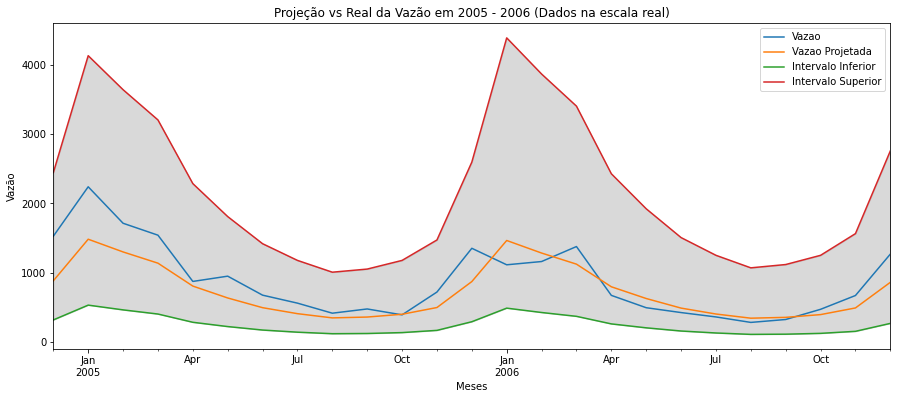

In [36]:
forecast_data = come_back_to_real(forecast_data)

threshold = datetime.strptime('2004-12-01', '%Y-%m-%d')

forecast_data = forecast_data.loc[forecast_data.index >= threshold]

print(forecast_data.tail(24))

plot_forecast(forecast_data, 'Projeção vs Real da Vazão em 2005 - 2006 (Dados na escala real)')

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6. Resultado</h2>
</div>
